In [2]:
# gp_ddm_generator.py
# 完整示例：用 GP 建模 S=[P,T,W,cond] -> DDM 参数 (v,a,t0,z)，然后模拟 trial-level DDM 数据
# 使用说明：
#   pip install numpy pandas matplotlib scikit-learn scipy
#   python gp_ddm_generator.py
# 注意：GP 训练对于 anchor 样本数较大时会很慢。示例中默认使用较小的 anchor 以保证能在个人电脑上完成。
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
import time
import os

np.random.seed(42)

In [4]:
# -------------------------
# 1) 原始 sigmoid 风格的 "anchor" 生成函数（用于产生训练数据）
#    （保留原来思路，便于 GP 学习到相似的 mapping）
# -------------------------
def k_P(P, k_min=0.01, k_max=0.15, gamma=0.1, P0=32):
    return k_min + (k_max - k_min) / (1 + np.exp(-gamma * (P - P0)))

def v_P_Function(P, P1=4, k_min=0.01, k_max=0.15, gamma=0.1, P0=32):
    k = k_P(P, k_min, k_max, gamma, P0)
    return 1 / (1 + np.exp(-k * (P - P1)))

alaph_self = 1.5
alaph_stranger = -0.4

def compute_v_sigmoid(T, P, condition_key):
    # 返回漂移速率 v（带噪声）
    T_0 = 100
    k_T = 0.01
    v_T = 1 / (1 + np.exp(-k_T * (T - T_0)))
    v_P = v_P_Function(P=P, P1=4, k_min=0.1, k_max=0.05, gamma=0.2, P0=32)
    v_0 = v_T * v_P * 3.0
    if condition_key == 1:
        v_1 = v_0 * (1 + alaph_self)
    else:
        v_1 = v_0 * (1 + alaph_stranger)
    return max(0.001, np.random.normal(v_1, 0.3))

def compute_a_sigmoid(M):
    # 返回阈值 a（带噪声），M = T + W
    k = 0.01
    M_0 = 600
    a_0 = 1 / (1 + np.exp(-k * (M - M_0))) * 3.0
    a_1 = a_0 * (1 + 0.2 if M > 600 else 1.0)
    return max(0.1, np.random.normal(a_1, 0.25))

def compute_t0_sigmoid(T, W):
    base = 0.35
    t0 = base - 0.00015 * T - 0.00005 * W
    return max(0.05, np.random.normal(t0, 0.02))

def compute_z_from_a(a):
    z = a/2.0 + np.random.normal(0., 0.03)
    return float(np.clip(z, 0.01, a - 0.01))

In [5]:
# -------------------------
# 2) 构造 anchor 数据集（S -> DDM 参数）以训练 GP
#    anchor_size: 可调。大则 GP 更精确但训练慢。
# -------------------------
def make_anchor_dataset(n=300):
    X = []
    Yv = []
    Ya = []
    Yt0 = []
    Yz = []
    for _ in range(n):
        P = np.random.randint(0, 150)       # same support as your original code
        T = np.random.randint(10, 600)      # ms
        W = np.random.randint(200, 1500)    # ms
        cond = np.random.choice([0, 1])     # 0 stranger, 1 self
        M = T + W
        v = compute_v_sigmoid(T, P, cond)
        a = compute_a_sigmoid(M)
        t0 = compute_t0_sigmoid(T, W)
        z = compute_z_from_a(a)
        X.append([P, T, W, cond])
        Yv.append(v)
        Ya.append(a)
        Yt0.append(t0)
        Yz.append(z)
    return np.array(X), np.array(Yv), np.array(Ya), np.array(Yt0), np.array(Yz)

In [6]:
# -------------------------
# 3) 训练 GP —— 四个独立的 GPR（v, a, t0, z）
#    为稳定训练，我们先对 X/Y 做 StandardScaler
# -------------------------
def train_gps(X_anchor, Yv_anchor, Ya_anchor, Yt0_anchor, Yz_anchor, kernel=None):
    scaler_X = StandardScaler().fit(X_anchor)
    Xs = scaler_X.transform(X_anchor)
    scaler_v = StandardScaler().fit(Yv_anchor.reshape(-1,1))
    ys_v = scaler_v.transform(Yv_anchor.reshape(-1,1)).ravel()
    scaler_a = StandardScaler().fit(Ya_anchor.reshape(-1,1))
    ys_a = scaler_a.transform(Ya_anchor.reshape(-1,1)).ravel()
    scaler_t0 = StandardScaler().fit(Yt0_anchor.reshape(-1,1))
    ys_t0 = scaler_t0.transform(Yt0_anchor.reshape(-1,1)).ravel()
    scaler_z = StandardScaler().fit(Yz_anchor.reshape(-1,1))
    ys_z = scaler_z.transform(Yz_anchor.reshape(-1,1)).ravel()

    if kernel is None:
        kernel = RBF(length_scale=np.ones(Xs.shape[1])) + WhiteKernel(noise_level=1e-3)

    # 注意：n_restarts_optimizer 和 anchor 大小会显著影响训练时间
    gp_v = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=False, n_restarts_optimizer=0, random_state=0).fit(Xs, ys_v)
    gp_a = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=False, n_restarts_optimizer=0, random_state=1).fit(Xs, ys_a)
    gp_t0 = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=False, n_restarts_optimizer=0, random_state=2).fit(Xs, ys_t0)
    gp_z = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=False, n_restarts_optimizer=0, random_state=3).fit(Xs, ys_z)

    scalers = {'X': scaler_X, 'v': scaler_v, 'a': scaler_a, 't0': scaler_t0, 'z': scaler_z}
    gps = {'v': gp_v, 'a': gp_a, 't0': gp_t0, 'z': gp_z}
    return scalers, gps

In [7]:
# -------------------------
# 4) 使用 GP 的预测（含不确定性）得到 DDM 参数
# -------------------------
def predict_params_with_uncertainty(P, T, W, cond, scalers, gps):
    S = np.array([[P, T, W, cond]])
    S_s = scalers['X'].transform(S)
    mv, sv = gps['v'].predict(S_s, return_std=True)
    ma, sa = gps['a'].predict(S_s, return_std=True)
    mt0, st0 = gps['t0'].predict(S_s, return_std=True)
    mz, sz = gps['z'].predict(S_s, return_std=True)
    # 在 scaled 空间里采样一个值，然后 inverse_transform 回原尺度
    sv_draw = np.random.normal(mv, sv)
    sa_draw = np.random.normal(ma, sa)
    st0_draw = np.random.normal(mt0, st0)
    sz_draw = np.random.normal(mz, sz)
    v_draw = float(scalers['v'].inverse_transform(sv_draw.reshape(-1,1)))
    a_draw = float(scalers['a'].inverse_transform(sa_draw.reshape(-1,1)))
    t0_draw = float(scalers['t0'].inverse_transform(st0_draw.reshape(-1,1)))
    z_draw = float(scalers['z'].inverse_transform(sz_draw.reshape(-1,1)))
    # 约束合理范围
    v_draw = max(0.001, v_draw)
    a_draw = max(0.1, a_draw)
    t0_draw = max(0.02, t0_draw)
    z_draw = float(np.clip(z_draw, 0.01, a_draw - 0.01))
    return {'v': v_draw, 'a': a_draw, 't0': t0_draw, 'z': z_draw}

In [8]:
# -------------------------
# 5) DDM 仿真器（简单 Euler-Maruyama）
# -------------------------
def simulate_ddm_trial(v, a, t0, z, dt=0.001, max_rt=5.0):
    evidence = z
    elapsed = 0.0
    while elapsed < max_rt:
        evidence += v * dt + np.random.normal(0, np.sqrt(dt))
        elapsed += dt
        if evidence >= a:
            return t0 + elapsed, 1
        if evidence <= 0:
            return t0 + elapsed, 0
    return np.nan, -1

In [9]:
# -------------------------
# 6) 将一切串起来：生成多被试多试次数据
# -------------------------
def generate_data_gp(num_subjects=200, trials_per_subject=60, anchor_size=400, verbose=True):
    # 1) make anchors
    X_anchor, Yv_anchor, Ya_anchor, Yt0_anchor, Yz_anchor = make_anchor_dataset(n=anchor_size)
    # 2) train GP
    if verbose:
        print("Training GP on anchor_size =", anchor_size)
    scalers, gps = train_gps(X_anchor, Yv_anchor, Ya_anchor, Yt0_anchor, Yz_anchor)
    # 3) simulate
    rows = []
    start = time.time()
    for subj in range(num_subjects):
        # 这里我们在被试层面固定 P,T,W（你也可以在 trial 层面随机化）
        P = np.random.randint(0, 150)
        T = np.random.randint(10, 600)
        W = np.random.randint(200, 1500)
        for trial in range(trials_per_subject):
            cond = 1 if (trial % 2 == 0) else 0
            params = predict_params_with_uncertainty(P, T, W, cond, scalers, gps)
            # 限制最大 RT：与原代码类似，用 (W + T)（ms）换算成 s
            max_rt = (W + T) / 1000.0 + 0.05
            RT, response = simulate_ddm_trial(params['v'], params['a'], params['t0'], params['z'], dt=0.001, max_rt=max_rt)
            rows.append({
                'subject': subj+1,
                'trial': trial+1,
                'P': P, 'T': T, 'W': W, 'M': T+W,
                'label': 'self' if cond==1 else 'stranger',
                'v': params['v'], 'a': params['a'], 't0': params['t0'], 'z': params['z'],
                'RT': RT, 'response': response
            })
    elapsed = time.time() - start
    if verbose:
        print(f"Simulation done: {num_subjects} subjects x {trials_per_subject} trials (elapsed {elapsed:.1f}s)")
    df = pd.DataFrame(rows)
    df_clean = df.dropna(subset=['RT'])
    df_clean = df_clean[df_clean['response'] != -1].reset_index(drop=True)
    return df_clean

Training GP on anchor_size = 300


c:\Users\蔡振辛\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\蔡振辛\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\蔡振辛\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\U

Simulation done: 5 subjects x 60 trials (elapsed 0.7s)
Simulated trials (clean): 243
Saved CSV to d:\GitHub_programe\GitHub\Guassion-Process-Experiment-Design\1_Code\Python_for_Generate\gp_ddm_simulation.csv


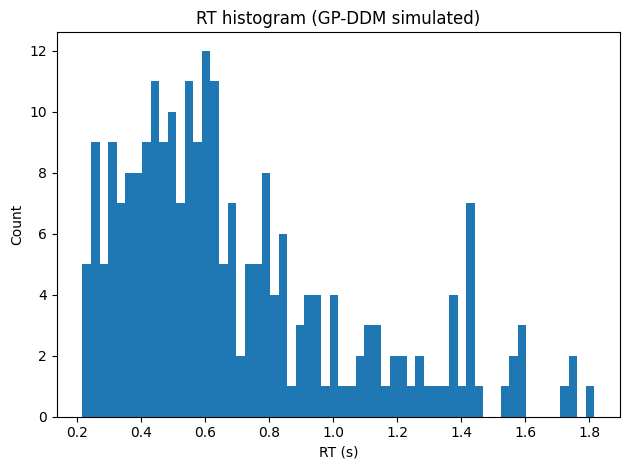

Mean RT by label:
       label        RT
0      self  0.550160
1  stranger  0.913391


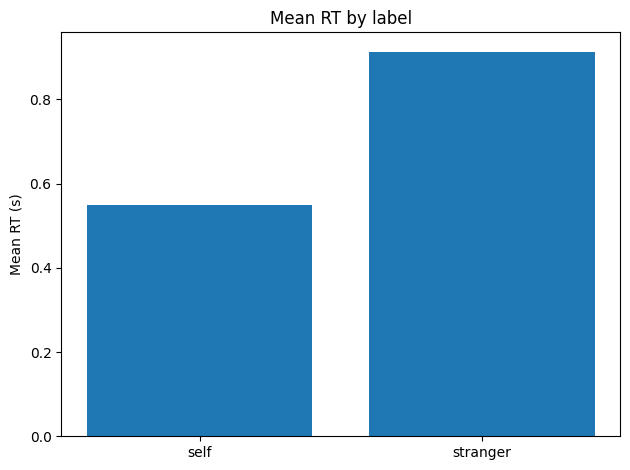

Accuracy by label:
       label  accuracy
0      self  1.000000
1  stranger  0.970297


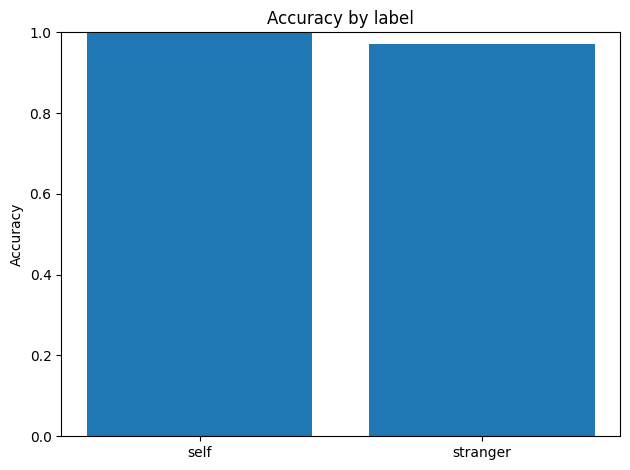

   subject  trial   P    T     W     M     label         v         a  \
0        1      1  84  392  1203  1595      self  7.407582  2.783361   
1        1      2  84  392  1203  1595  stranger  1.257363  3.429130   
2        1      3  84  392  1203  1595      self  7.301548  2.666590   
3        1      5  84  392  1203  1595      self  6.814827  2.244809   
4        1      6  84  392  1203  1595  stranger  1.964737  5.388860   
5        1      7  84  392  1203  1595      self  7.208763  3.952211   
6        1      9  84  392  1203  1595      self  6.821510  3.461340   
7        1     10  84  392  1203  1595  stranger  1.742604  3.044023   
8        1     11  84  392  1203  1595      self  7.021433  4.796240   
9        1     12  84  392  1203  1595  stranger  2.483508  2.772134   

         t0         z        RT  response  
0  0.220353  1.679117  0.308353         1  
1  0.315695  1.404862  1.046695         1  
2  0.271497  1.430067  0.369497         1  
3  0.265005  0.821717  0.513005

In [10]:
# -------------------------
# 7) 主程序与示例
# -------------------------
if __name__ == "__main__":
    # 可调参数
    NUM_SUBJECTS = 5         # 被试数（本地机慢时可减小）
    TRIALS_PER_SUBJECT = 60    # 每被试试次数
    ANCHOR_SIZE = 300          # anchor 数量（越大 GP 学得越好但训练越慢）
    OUTPUT_CSV = "gp_ddm_simulation.csv"

    df_sim = generate_data_gp(num_subjects=NUM_SUBJECTS, trials_per_subject=TRIALS_PER_SUBJECT, anchor_size=ANCHOR_SIZE, verbose=True)
    print("Simulated trials (clean):", len(df_sim))
    df_sim.to_csv(OUTPUT_CSV, index=False)
    print("Saved CSV to", os.path.abspath(OUTPUT_CSV))

    # 简单汇总与绘图（matplotlib）
    plt.figure()
    plt.hist(df_sim['RT'].values, bins=60)
    plt.xlabel("RT (s)"); plt.ylabel("Count"); plt.title("RT histogram (GP-DDM simulated)")
    plt.tight_layout(); plt.show()

    mean_by_label = df_sim.groupby('label')['RT'].mean().reset_index()
    print("Mean RT by label:\n", mean_by_label)
    plt.figure()
    plt.bar(mean_by_label['label'], mean_by_label['RT'])
    plt.ylabel("Mean RT (s)"); plt.title("Mean RT by label"); plt.tight_layout(); plt.show()

    acc_by_label = df_sim.groupby('label')['response'].mean().reset_index()
    acc_by_label['accuracy'] = acc_by_label['response']
    print("Accuracy by label:\n", acc_by_label[['label','accuracy']])
    plt.figure()
    plt.bar(acc_by_label['label'], acc_by_label['accuracy']); plt.ylim(0,1); plt.ylabel("Accuracy"); plt.title("Accuracy by label"); plt.tight_layout(); plt.show()

    print(df_sim.head(10))
